# Optimización de la Gestión de Cobranza: Desarrollo e Implementación de un Modelo Predictivo


## Introducción

Desarrollar e implementar un modelo predictivo que optimice la recuperación de cartera vencida en una empresa de cobranza, mediante el análisis de datos históricos para predecir el comportamiento de pago de los clientes. Este modelo tiene como finalidad mantener la tasa de recuperación de cuentas reduciendo los costos asociados, y mejorar la relación con los clientes, contribuyendo así a la sostenibilidad financiera de la organización.


## 1. Instalación de paquetes 

In [1]:
pip install sqlalchemy pyodbc pandas

Note: you may need to restart the kernel to use updated packages.


## 2. Importación de librerías necesarias


In [2]:
import pyodbc
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
from sqlalchemy import create_engine
from sklearn.pipeline import Pipeline 
from sklearn.impute import SimpleImputer 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.neural_network import MLPClassifier 
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, auc 
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy.stats import chi2_contingency
import numpy as np
from sqlalchemy import create_engine
import urllib


## 3. Configuración de la conexión a la base de datos

In [3]:
# Parámetros de la base de datos
server = r'SMPSPRAP5003\INSBDD001'  # Nombre del servidor
databaseTFM = 'TFM_MODELO_PREDICTIVO'  # Nombre de la base de datos

# Crear la cadena de conexión para autenticación de Windows
conn_stringTFM = f'DRIVER={{ODBC Driver 17 for SQL Server}};SERVER={server};DATABASE={databaseTFM};Trusted_Connection=yes'


## 4. Conexión a la base de datos y carga de datos

In [4]:
# Codificar la cadena de conexión para usar en SQLAlchemy
params = urllib.parse.quote_plus(conn_stringTFM)

# Crear la URL de conexión para SQLAlchemy
conn_stringSQLAlchemy = f"mssql+pyodbc:///?odbc_connect={params}"

# Establecer el tamaño del chunk
chunksize = 1000  # Puedes ajustar este tamaño según la memoria disponible

try:
    # Crear el motor de conexión usando SQLAlchemy
    engine = create_engine(conn_stringSQLAlchemy)
    print("Conexión exitosa")
    
    # Definir la nueva consulta SQL
    query = """SELECT identificacionCliente, rucCliente, rucEmpresaDependiente, tipoPersona, actividad,
    rangoIngresoCliente, rangoIngresoConyuge, edad, operacion, diasMoraOperacion, probabilidadPagoCliente, 
    valorRiesgoGlobal, valorRiesgoTotal, valorExigibleOperacion, canalGestion, valorPromesa, valorPagadoPromesa, 
    valorPagadoPago, genero, estadoCivil, profesion, nacionalidad, tieneProfesion, tuvoGestion, tuvoPromesaDePago, 
    hizoPago, estaEnOperacionBuro 
    FROM [TFM_MODELO_PREDICTIVO].[dbo].[tbModeloPredictivoCobranza]"""
    
    # Leer la consulta SQL en un DataFrame en "chunks"
    chunk_list = []  # Lista para almacenar los chunks
    for chunk in pd.read_sql(query, engine, chunksize=chunksize):
        chunk_list.append(chunk)
    
    # Concatenar los chunks en un único DataFrame
    df_ModeloTFM = pd.concat(chunk_list, ignore_index=True)
  
except Exception as e:
    print("Error al conectar:", e)

finally:
    # No es necesario cerrar la conexión explícitamente con SQLAlchemy
    print("Conexión cerrada (automáticamente por SQLAlchemy)")

Conexión exitosa
Conexión cerrada (automáticamente por SQLAlchemy)


# 5 ANALISÍS EDA

## 5.1 Carga y Revisión Inicial de los Datos

In [5]:
# Mostrar las primeras filas
print(df_ModeloTFM.head(5))


  identificacionCliente      rucCliente rucEmpresaDependiente tipoPersona  \
0        00000803441005  00803441005001                           NATURAL   
1        00000803441005  00803441005001                           NATURAL   
2        00000803762558                                           NATURAL   
3        00000803762558                                           NATURAL   
4        00000804027936                                           NATURAL   

               actividad rangoIngresoCliente rangoIngresoConyuge  edad  \
0  COMERCIO AL POR MENOR                1000                      24.0   
1  COMERCIO AL POR MENOR                1000                      24.0   
2                                       1000                      30.0   
3                                       1000                      30.0   
4                                       1000                      23.0   

          operacion  diasMoraOperacion  ... valorPagadoPago     genero  \
0  000000800286642

In [6]:
# Obtener un resumen de los datos
print(df_ModeloTFM.info())

# Estadísticas descriptivas de las variables numéricas
print(df_ModeloTFM.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345051 entries, 0 to 345050
Data columns (total 27 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   identificacionCliente    345051 non-null  object 
 1   rucCliente               345051 non-null  object 
 2   rucEmpresaDependiente    345051 non-null  object 
 3   tipoPersona              345051 non-null  object 
 4   actividad                345051 non-null  object 
 5   rangoIngresoCliente      345051 non-null  object 
 6   rangoIngresoConyuge      345051 non-null  object 
 7   edad                     336621 non-null  float64
 8   operacion                345051 non-null  object 
 9   diasMoraOperacion        345051 non-null  int64  
 10  probabilidadPagoCliente  345051 non-null  object 
 11  valorRiesgoGlobal        345051 non-null  float64
 12  valorRiesgoTotal         345051 non-null  float64
 13  valorExigibleOperacion   345051 non-null  float64
 14  cana

## 5.2 Análisis de Valores Faltantes


In [7]:
# Revisar los valores nulos en el dataset
missing_data = df_ModeloTFM.isnull().sum()
missing_data_percentage = (missing_data / len(df_ModeloTFM)) * 100

# Mostrar las columnas con más de 10% de valores faltantes
print(missing_data_percentage[missing_data_percentage > 10])


valorPromesa          83.308265
valorPagadoPromesa    83.308265
genero                18.958357
estadoCivil           18.958357
profesion             19.085295
nacionalidad          19.760267
dtype: float64


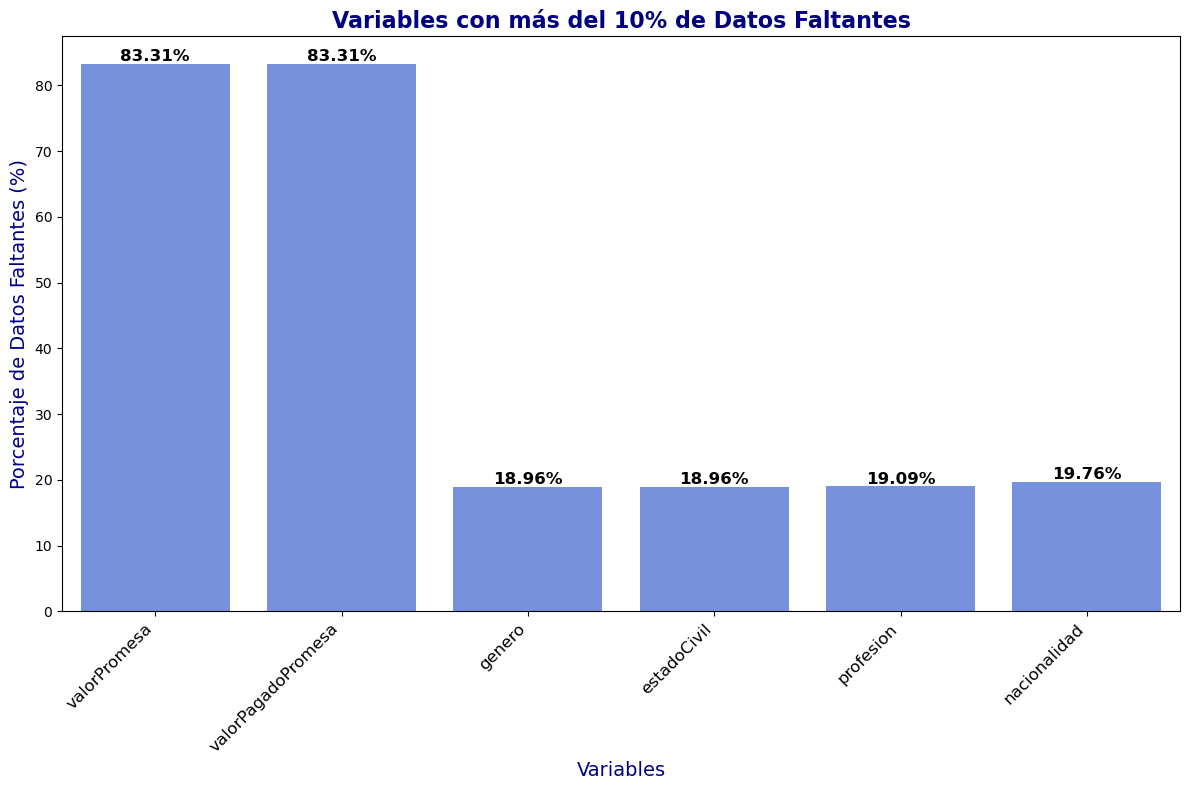

In [8]:
# Crear un gráfico más profesional
columnas_faltantes = missing_data_percentage[missing_data_percentage > 10]
plt.figure(figsize=(12, 8))  # Tamaño más grande para mayor claridad

# Usamos una paleta de colores atractiva y profesional
sns.set_palette("coolwarm")  # Paleta de colores "coolwarm" para un contraste agradable

# Crear el gráfico de barras con las columnas con datos faltantes
ax = sns.barplot(x=columnas_faltantes.index, y=columnas_faltantes.values, errorbar=None)

# Ajustar el título y las etiquetas de los ejes
ax.set_title('Variables con más del 10% de Datos Faltantes', fontsize=16, fontweight='bold', color='navy')
ax.set_xlabel('Variables', fontsize=14, color='darkblue')
ax.set_ylabel('Porcentaje de Datos Faltantes (%)', fontsize=14, color='darkblue')

# Hacer que las etiquetas del eje X sean legibles
plt.xticks(rotation=45, ha='right', fontsize=12)

# Agregar los porcentajes encima de las barras
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=12, fontweight='bold', color='black', 
                xytext=(0, 5), textcoords='offset points')

# Mejorar la legibilidad con un espaciado adecuado
plt.tight_layout()

# Mostrar el gráfico
plt.show()


## 5.3 Análisis Univariado: Distribución de Variables

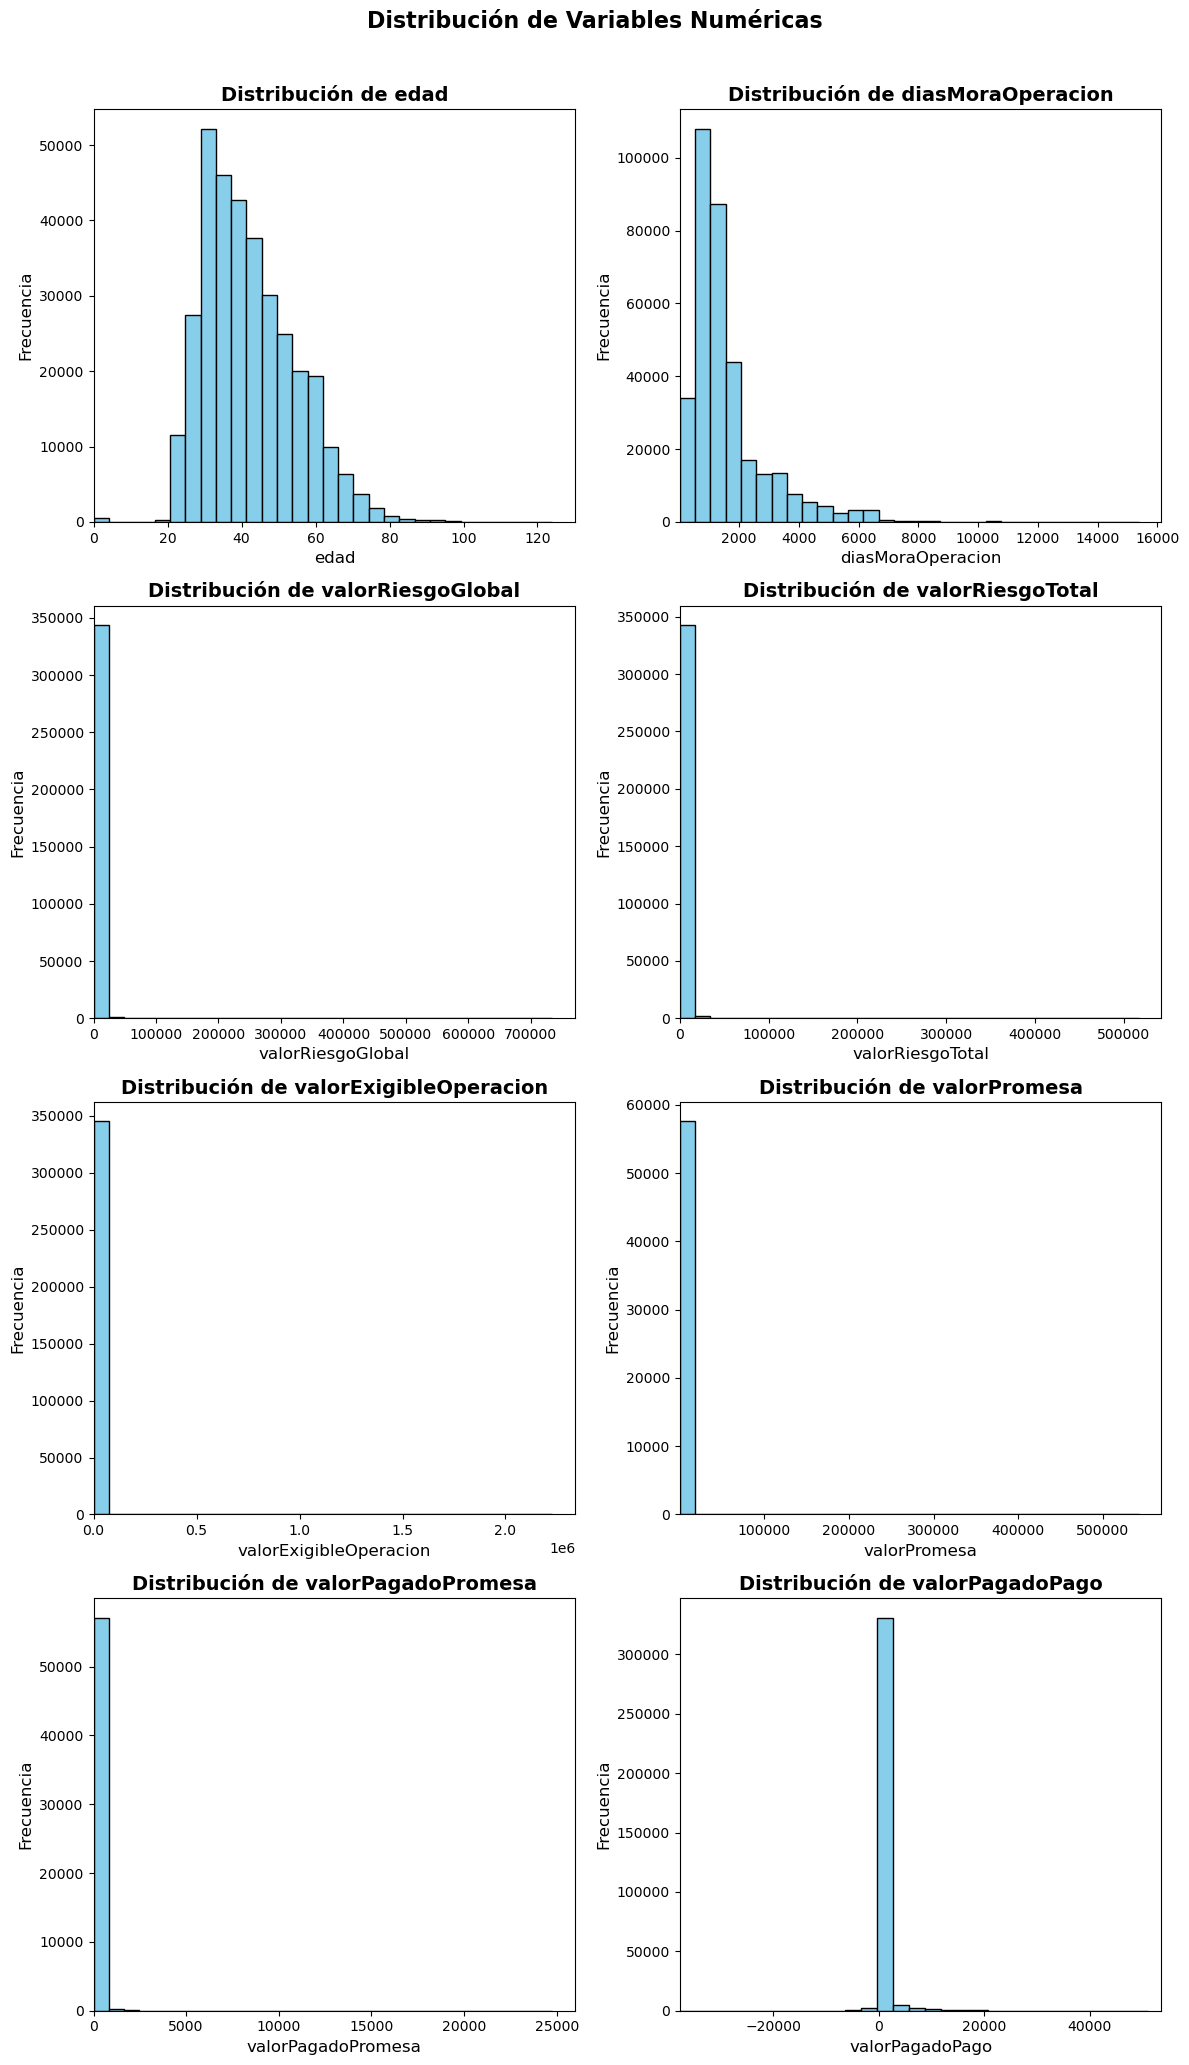

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Suposición: los datos están en df_ModeloTFM
# Lista de variables numéricas para graficar
columnas_numericas = ['edad', 'diasMoraOperacion', 'valorRiesgoGlobal', 'valorRiesgoTotal',
                      'valorExigibleOperacion', 'valorPromesa', 'valorPagadoPromesa', 
                      'valorPagadoPago']

# Definir el número de columnas y filas para los subgráficos
n_columnas = len(columnas_numericas)
n_filas = (n_columnas // 2) + (n_columnas % 2)  # Redondeamos hacia arriba si hay un número impar

# Crear subgráficos
fig, ax = plt.subplots(n_filas, 2, figsize=(12, 5 * n_filas))  # Tamaño ajustado para mejor visibilidad

# Ajuste para cuando hay solo una fila de subgráficos
if n_filas == 1:
    ax = ax.reshape(1, 2)  # Redefinir ax a una matriz 1x2

# Graficar la distribución de cada variable numérica
for i, col in enumerate(columnas_numericas):
    # Determinar el eje específico para cada gráfico
    ax_ = ax[i // 2, i % 2]
    
    # Crear el histograma básico
    ax_.hist(df_ModeloTFM[col], bins=30, color='skyblue', edgecolor='black')
    
    # Establecer título y etiquetas
    ax_.set_title(f'Distribución de {col}', fontsize=14, fontweight='bold')
    ax_.set_xlabel(col, fontsize=12)
    ax_.set_ylabel('Frecuencia', fontsize=12)
    
    # Ajustar la escala del eje X de forma automática
    ax_.set_xlim(left=df_ModeloTFM[col].min() * 0.95, right=df_ModeloTFM[col].max() * 1.05)
    
    # Mejorar la visibilidad de las escalas
    ax_.tick_params(axis='both', which='major', labelsize=10)

# Ajuste del layout para evitar que los gráficos se solapen
plt.tight_layout()

# Título global para todos los subgráficos
plt.suptitle('Distribución de Variables Numéricas', fontsize=16, fontweight='bold', y=1.03)

# Mostrar los gráficos
plt.show()



## 5.4 Análisis Bivariado: Relación entre Variables

### 5.4.1 Correlación entre variables numéricas: (matriz de correlación)

In [11]:
# Paso 1: Seleccionar solo las columnas numéricas
df_ModeloTFM_numerico = df_ModeloTFM.select_dtypes(include=['int64', 'float64'])

# Paso 2: Eliminar filas con valores nulos en las columnas numéricas (opcional)
df_ModeloTFM_numerico = df_ModeloTFM_numerico.dropna()

# Paso 3: Calcular la matriz de correlación
correlacion_matrix = df_ModeloTFM_numerico.corr()
# Paso 4: Imprimir la matriz de correlación como datos
print(correlacion_matrix)

                            edad  diasMoraOperacion  valorRiesgoGlobal  \
edad                    1.000000           0.146045           0.077668   
diasMoraOperacion       0.146045           1.000000          -0.087216   
valorRiesgoGlobal       0.077668          -0.087216           1.000000   
valorRiesgoTotal        0.079285          -0.105430           0.911488   
valorExigibleOperacion  0.064969          -0.034735           0.872809   
valorPromesa            0.000900           0.004837           0.036956   
valorPagadoPromesa      0.010192          -0.053670           0.124192   
valorPagadoPago        -0.004364          -0.096402           0.180456   
tieneProfesion          0.110172          -0.004425          -0.157446   
tuvoGestion                  NaN                NaN                NaN   
tuvoPromesaDePago            NaN                NaN                NaN   
hizoPago                0.107470          -0.080306           0.044566   
estaEnOperacionBuro     0.011841      

#### Visualización de la matriz de correlación

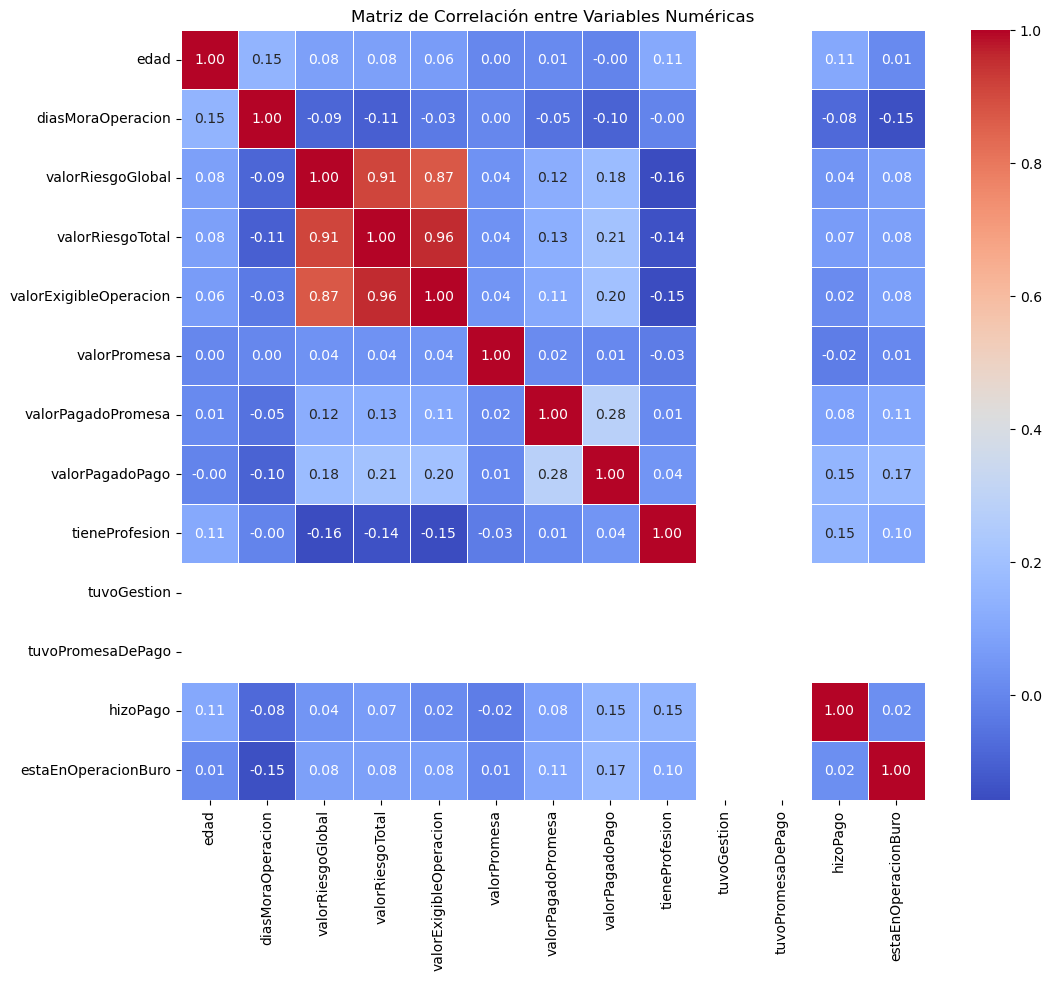

In [12]:


# Paso 5: Visualizar la matriz de correlación utilizando un heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlacion_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlación entre Variables Numéricas')
plt.show()

### 5.4.2 Relación entre variables categóricas - Análisis estadístico (Cramér's V)

In [13]:
def cramers_v(chi2, n, k):
    """Calcula el coeficiente de Cramér"""
    return np.sqrt(chi2 / (n * (k - 1)))

# Crear una matriz de contingencia entre 'tipoPersona' y 'actividad'
contingencia_matrix = pd.crosstab(df_ModeloTFM['tipoPersona'], df_ModeloTFM['actividad'])

# Realizar la prueba de Chi-cuadrado
chi2, p, dof, expected = chi2_contingency(contingencia_matrix)

# Número de observaciones
n = contingencia_matrix.sum().sum()

# Número de categorías en cada variable
k = min(contingencia_matrix.shape)  # El número mínimo de categorías entre las dos variables

# Calcular el coeficiente de Cramér
cramers_coeficiente = cramers_v(chi2, n, k)
print(f"Coeficiente de Cramér V: {cramers_coeficiente}")

Coeficiente de Cramér V: 0.6836101017582318


#### Análisis de Variables Categóricas y Cálculo del Coeficiente de Cramér

In [14]:
# Lista de variables categóricas a analizar
columna_categorica = ['tipoPersona', 'actividad', 'rangoIngresoCliente', 'genero', 'canalGestion','profesion','nacionalidad','probabilidadPagoCliente']

# Crear una lista para almacenar los coeficientes de Cramér
cramers_matrix = pd.DataFrame(index=columna_categorica, columns=columna_categorica)

# Calcular el coeficiente de Cramér para cada par de variables categóricas
for col1 in columna_categorica:
    for col2 in columna_categorica:
        if col1 != col2:
            # Crear la matriz de contingencia entre las dos variables
            contingencia_matrix = pd.crosstab(df_ModeloTFM[col1], df_ModeloTFM[col2])
            
            # Realizar la prueba de Chi-cuadrado
            chi2, p, dof, expected = chi2_contingency(contingencia_matrix)
            
            # Calcular el coeficiente de Cramér
            cramers_matrix.loc[col1, col2] = cramers_v(chi2, contingencia_matrix.sum().sum(), min(contingencia_matrix.shape))

# Mostrar la matriz de relaciones
print(cramers_matrix)


                        tipoPersona actividad rangoIngresoCliente    genero  \
tipoPersona                     NaN   0.68361             0.32574  0.045718   
actividad                   0.68361       NaN            0.217463  0.166512   
rangoIngresoCliente         0.32574  0.217463                 NaN  0.057109   
genero                     0.045718  0.166512            0.057109       NaN   
canalGestion               0.046058  0.052585            0.080671   0.03054   
profesion                  0.145119  0.199315            0.141567  0.500145   
nacionalidad               0.021777  0.030905            0.030421  0.025171   
probabilidadPagoCliente     0.00196  0.003168            0.011595  0.002919   

                        canalGestion profesion nacionalidad  \
tipoPersona                 0.046058  0.145119     0.021777   
actividad                   0.052585  0.199315     0.030905   
rangoIngresoCliente         0.080671  0.141567     0.030421   
genero                       0.03054

#### Visualización de la Matriz de Cramér

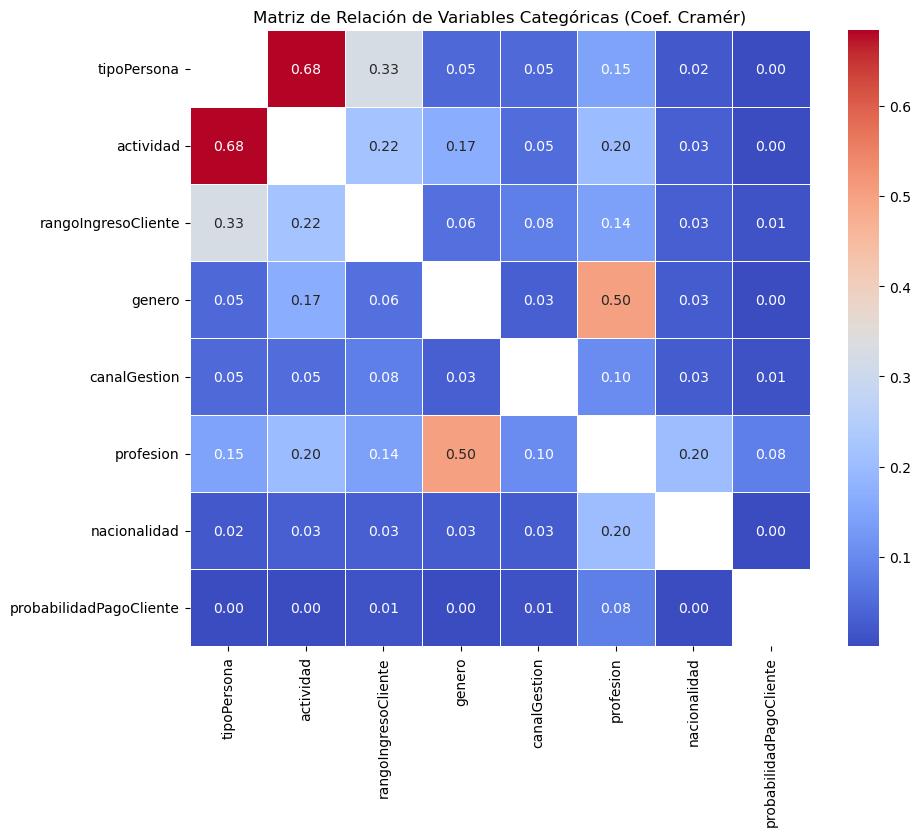

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualizar la matriz de relaciones de Cramér
plt.figure(figsize=(10, 8))
sns.heatmap(cramers_matrix.astype(float), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Relación de Variables Categóricas (Coef. Cramér)')
plt.show()

## 5.5. Detección de Outliers en Variables Numéricas
## 5.5.1 Calcular el número de outliers utilizando el rango intercuartílico (IQR)

In [15]:
def detectar_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    return len(outliers)

# Calcular los outliers por columna
outliers_por_columna = {col: detectar_outliers(df_ModeloTFM, col) for col in df_ModeloTFM_numerico}
tabla_outliers = pd.DataFrame(outliers_por_columna.items(), columns=['Variable', 'Número de Outliers'])
print("\n### Outliers (Valores Atípicos) ###")
print(tabla_outliers)



### Outliers (Valores Atípicos) ###
                  Variable  Número de Outliers
0                     edad                3577
1        diasMoraOperacion               33863
2        valorRiesgoGlobal               28696
3         valorRiesgoTotal               29235
4   valorExigibleOperacion               29879
5             valorPromesa                4701
6       valorPagadoPromesa                3528
7          valorPagadoPago               56318
8           tieneProfesion               65854
9              tuvoGestion                   0
10       tuvoPromesaDePago               57595
11                hizoPago               56319
12     estaEnOperacionBuro               22888


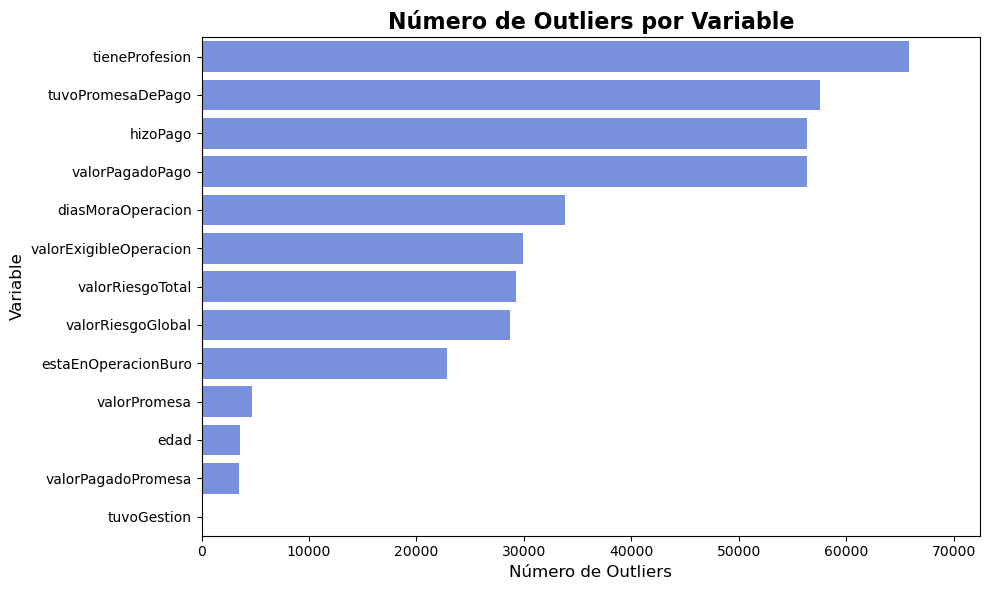

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Datos de outliers en un DataFrame
data_outliers = {
    'Variable': ['edad', 'diasMoraOperacion', 'valorRiesgoGlobal', 'valorRiesgoTotal', 
                 'valorExigibleOperacion', 'valorPromesa', 'valorPagadoPromesa', 
                 'valorPagadoPago', 'tieneProfesion', 'tuvoGestion', 
                 'tuvoPromesaDePago', 'hizoPago', 'estaEnOperacionBuro'],
    'Número de Outliers': [3577, 33863, 28696, 29235, 29879, 4701, 3528, 56318, 
                           65854, 0, 57595, 56319, 22888]
}

# Convertir a DataFrame
df_outliers = pd.DataFrame(data_outliers)

# Ordenar el DataFrame por el número de outliers (opcional)
df_outliers_sorted = df_outliers.sort_values(by='Número de Outliers', ascending=False)

# Configuración del gráfico
plt.figure(figsize=(10, 6))

# Crear un gráfico de barras (sin usar el parámetro palette)
sns.barplot(x='Número de Outliers', y='Variable', data=df_outliers_sorted)

# Establecer título y etiquetas
plt.title('Número de Outliers por Variable', fontsize=16, fontweight='bold')
plt.xlabel('Número de Outliers', fontsize=12)
plt.ylabel('Variable', fontsize=12)

# Mejorar la visibilidad de las escalas
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Ajustar los límites del eje X para que sea proporcional a los outliers más altos
plt.xlim(0, df_outliers_sorted['Número de Outliers'].max() * 1.1)

# Mostrar el gráfico
plt.tight_layout()
plt.show()


## Análisis de la Variable Objetivo - "hizoPago"
## Visualización de la variable objetivo


Distribución de Pagos (Sí / No):
+------------+---------------+------------------+
|   hizoPago |   Total Pagos |   Porcentaje (%) |
+============+===============+==================+
|          0 |        288732 |          83.6781 |
+------------+---------------+------------------+
|          1 |         56319 |          16.3219 |
+------------+---------------+------------------+


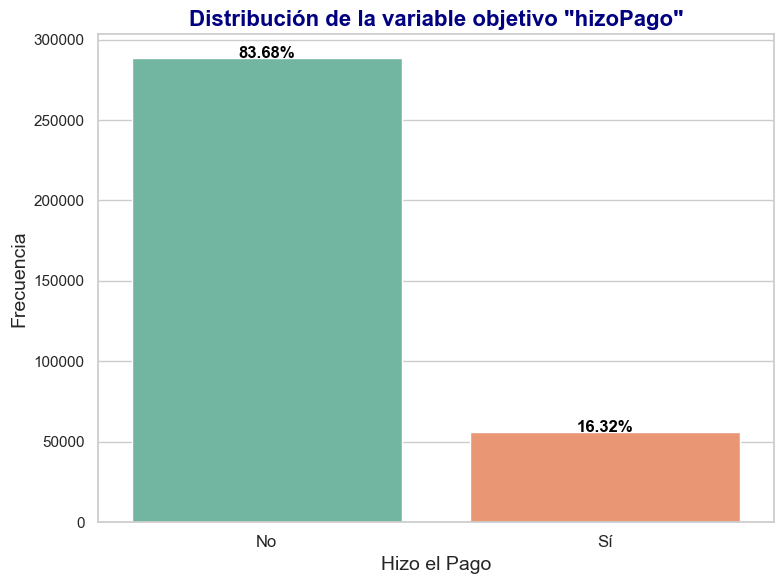

In [17]:
# Calcular el total de pagos por "Sí" (1) y "No" (0)
total_pagos = df_ModeloTFM['hizoPago'].value_counts()

# Calcular los porcentajes
porcentajes_pagos = df_ModeloTFM['hizoPago'].value_counts(normalize=True) * 100

# Asegurarnos de que las etiquetas '0' (No) y '1' (Sí) estén en la tabla
tabla_pagos = pd.DataFrame({
    'Total Pagos': total_pagos,
    'Porcentaje (%)': porcentajes_pagos
})

# Reindexar para asegurarnos de que ambas categorías (0 y 1) estén presentes
tabla_pagos = tabla_pagos.reindex([0, 1], fill_value=0)

# Mostrar la tabla
from tabulate import tabulate
print("\nDistribución de Pagos (Sí / No):")
print(tabulate(tabla_pagos, headers='keys', tablefmt='grid'))

import matplotlib.pyplot as plt
import seaborn as sns

# Configurar el estilo de Seaborn para un gráfico profesional
sns.set(style="whitegrid")  # Fondo blanco con líneas de cuadrícula

# Crear el gráfico
plt.figure(figsize=(8, 6))  # Tamaño del gráfico

# Utilizar countplot para la variable 'hizoPago'
ax = sns.countplot(data=df_ModeloTFM, x='hizoPago', hue='hizoPago', palette='Set2', legend=False)

# Configuración de títulos y etiquetas
ax.set_title('Distribución de la variable objetivo "hizoPago"', fontsize=16, fontweight='bold', color='navy')
ax.set_xlabel('Hizo el Pago', fontsize=14)
ax.set_ylabel('Frecuencia', fontsize=14)

# Etiquetas en los ejes X
ax.set_xticks([0, 1])  # Establecer las ubicaciones de los ticks
ax.set_xticklabels(['No', 'Sí'], fontsize=12)

# Agregar los porcentajes encima de las barras
total = len(df_ModeloTFM)  # Total de registros
for p in ax.patches:
    height = p.get_height()  # Altura de la barra
    ax.text(p.get_x() + p.get_width() / 2, height + 20, f'{height / total * 100:.2f}%', 
            ha="center", fontsize=12, color='black', fontweight='bold')

# Mejorar la legibilidad con más espacio en los ejes
plt.tight_layout()

# Mostrar el gráfico
plt.show()




## 5.6 ANALISÍS DE DATOS ENCONTRADOS

### 5.6.1 Distribución de Pagos por Canal de Gestión y Estado Civil

estadoCivil                            CASADO  DIVORCIADO  SOLTERO  \
canalGestion                                                         
GESTION AUTOMATICA CORREO ELECTRONICO    5266        1195    10156   
GESTION AUTOMATICA LLAMADA SIN AGENTE     792         299      420   
GESTION AUTOMATICA TEXTO CORTO              1           0        0   
GESTION MANUAL                           1903         444     5102   
MARCADOR AUTOMATICO                     52772       11585    71170   
SOFTWARE DE GESTION                     41955        8560    59206   
VISITA TERRENO                           1735         301     1468   

estadoCivil                            UNION LIBRE  VIUDO  
canalGestion                                               
GESTION AUTOMATICA CORREO ELECTRONICO          107    123  
GESTION AUTOMATICA LLAMADA SIN AGENTE            6     51  
GESTION AUTOMATICA TEXTO CORTO                   0      0  
GESTION MANUAL                                  39     83  
MARCADOR 

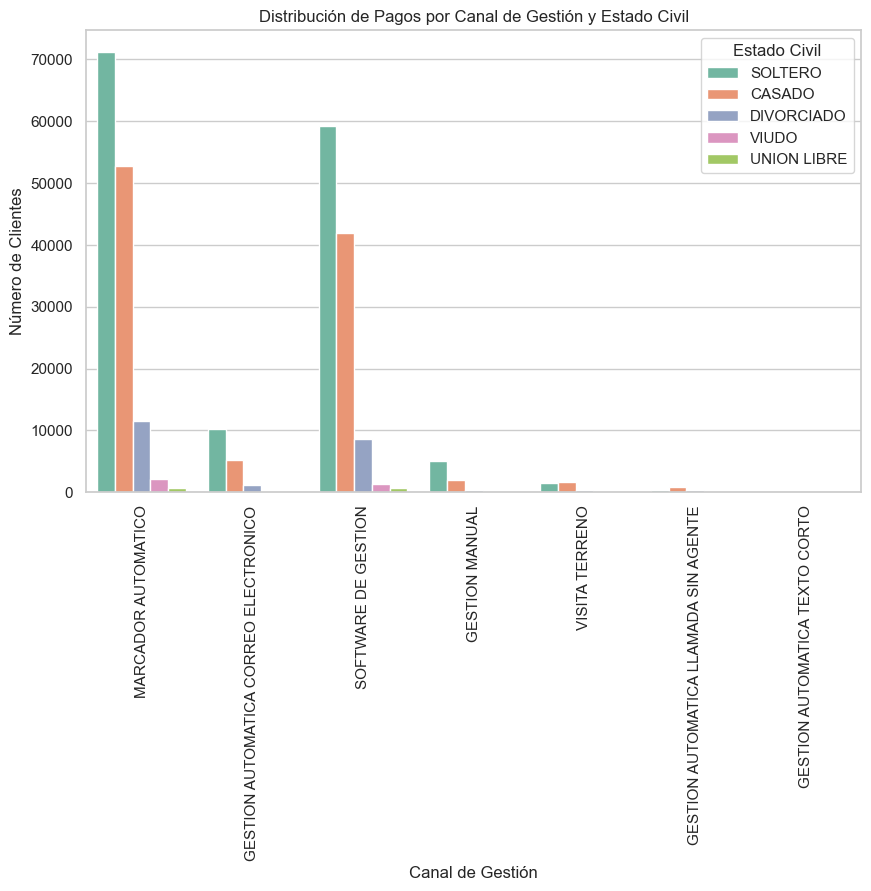

In [18]:
# Crear una tabla de contingencia entre 'canalGestion' y 'estadoCivil'
tablaContingencia = pd.crosstab(df_ModeloTFM['canalGestion'], df_ModeloTFM['estadoCivil'])

# Mostrar la tabla
print(tablaContingencia)

# Crear un gráfico de barras apiladas
plt.figure(figsize=(10, 6))
sns.countplot(data=df_ModeloTFM, x='canalGestion', hue='estadoCivil', palette='Set2')

# Mostrar el título y etiquetas
plt.title('Distribución de Pagos por Canal de Gestión y Estado Civil')
plt.xlabel('Canal de Gestión')
plt.xticks(rotation=90)
plt.ylabel('Número de Clientes')
plt.legend(title='Estado Civil')

plt.show()


### 5.6.2 Distribución de Pagos por Género y Profesión

hizoPago                       0      1     All
tieneProfesion genero                          
0              FEMENINO      298     52     350
               MASCULINO      61     27      88
1              FEMENINO    92365  24741  117106
               MASCULINO  134058  28033  162091
All                       226782  52853  279635


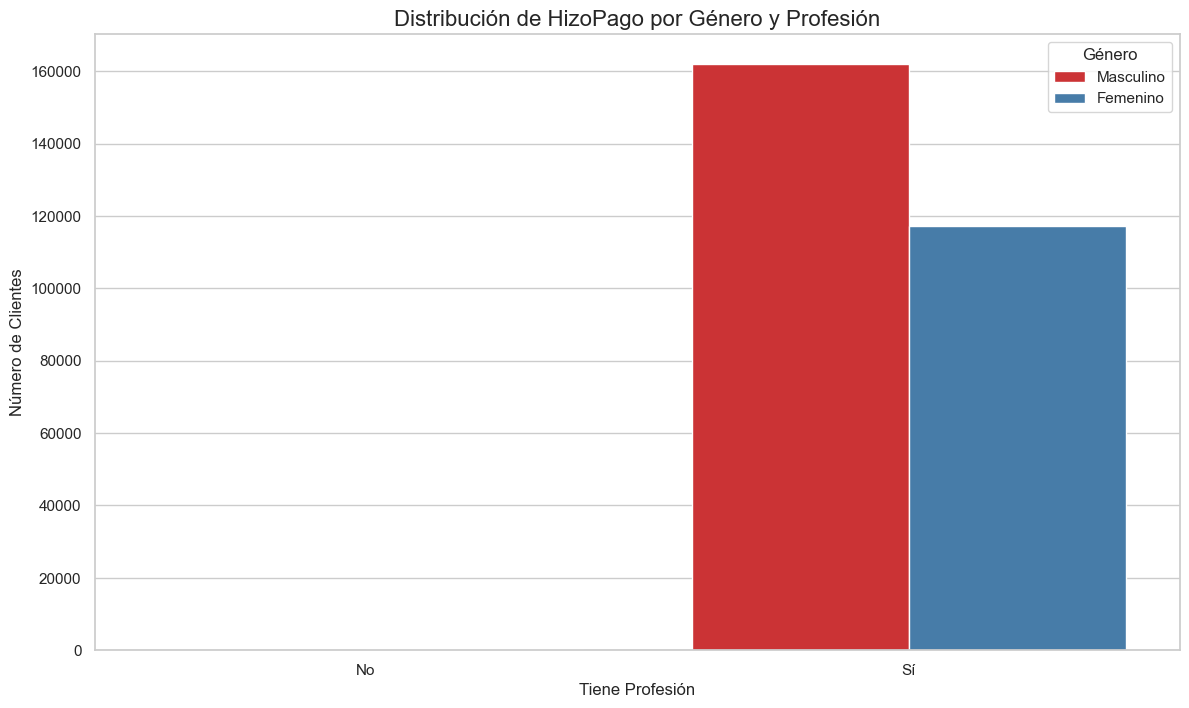

In [19]:
# Crear una tabla de contingencia entre 'tieneProfesion', 'genero' y 'hizoPago'
tablaContingenciaProfesion = pd.crosstab([df_ModeloTFM['tieneProfesion'], df_ModeloTFM['genero']], df_ModeloTFM['hizoPago'], margins=True)

# Mostrar la tabla
print(tablaContingenciaProfesion)

# Crear un gráfico combinado donde género y tieneProfesion son las variables
plt.figure(figsize=(14, 8))

# Graficar las barras agrupadas de 'tieneProfesion' y 'genero' vs 'hizoPago'
sns.countplot(x='tieneProfesion', hue='genero', data=df_ModeloTFM, palette='Set1', dodge=True)

# Personalización
plt.title('Distribución de HizoPago por Género y Profesión', fontsize=16)
plt.xlabel('Tiene Profesión', fontsize=12)
plt.ylabel('Número de Clientes', fontsize=12)
plt.xticks([0, 1], ['No', 'Sí'], rotation=0)  # Ajustamos etiquetas de 'tieneProfesion'
plt.legend(title='Género', labels=['Masculino', 'Femenino'])

plt.show()


### 5.6.3 Distribución de Edad según el Pago Realizado

hizoPago     0    1
edad               
0.0        427  153
19.0         9    9
20.0       201   97
21.0       865  295
22.0      1500  505
...        ...  ...
108.0        2    0
109.0        1    0
110.0        1    0
119.0        1    0
124.0        3    0

[95 rows x 2 columns]


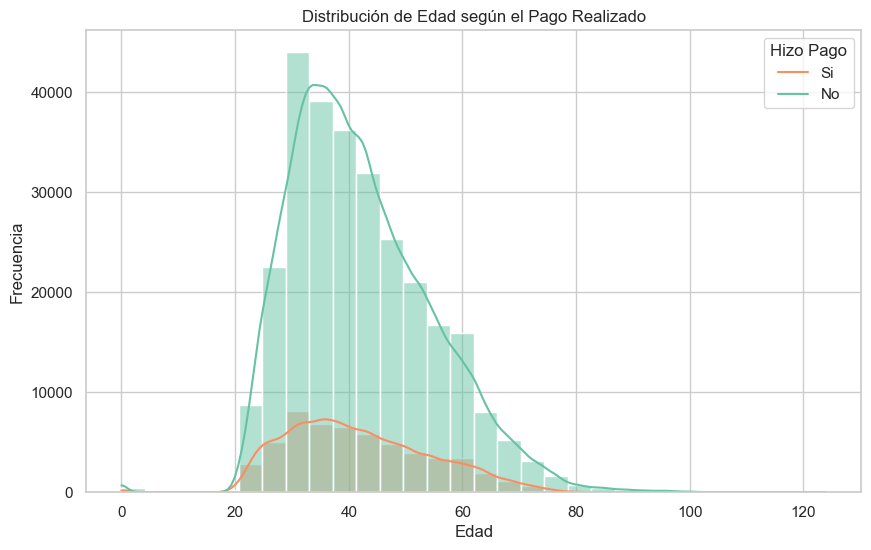

In [20]:
# Crear una tabla de contingencia para 'edad' y 'hizoPago'
tablaContingenciaEdad = pd.crosstab(df_ModeloTFM['edad'], df_ModeloTFM['hizoPago'])

# Mostrar la tabla
print(tablaContingenciaEdad)

# Distribución de edad según si hizo o no el pago
plt.figure(figsize=(10, 6))
sns.histplot(data=df_ModeloTFM, x='edad', hue='hizoPago', kde=True, bins=30, palette='Set2')
plt.title('Distribución de Edad según el Pago Realizado')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.legend(title='Hizo Pago', labels=['Si', 'No'])
plt.show()


### 5.6.4 Pagos por Rango de Ingreso

,rangoIngresoCliente,hizoPago,TotalPagos
0,0.00,No,19322
1,0.00,Sí,3088
2,200.50,No,32
3,200.50,Sí,12
4,500.00,No,7269
5,500.00,Sí,1118
6,700.00,No,61549
7,700.00,Sí,7553
8,1000.00,No,72623
9,1000.00,Sí,16812


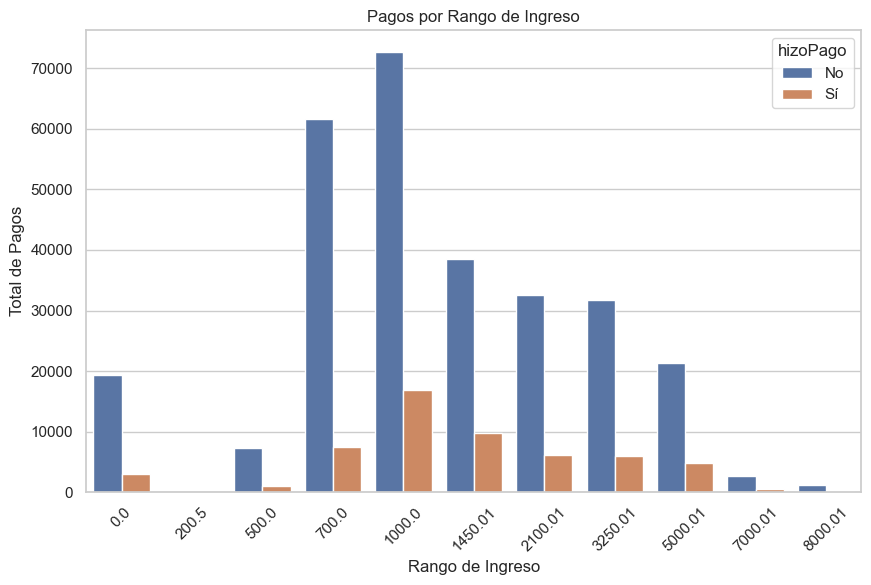

In [21]:
# Convertir 'rangoIngresoCliente' a numérico (esto maneja cadenas o tipos mixtos)
df_ModeloTFM['rangoIngresoCliente'] = pd.to_numeric(df_ModeloTFM['rangoIngresoCliente'], errors='coerce')

# Reemplazar 0 por 'No' y 1 por 'Sí' en la columna 'hizoPago'
df_ModeloTFM['hizoPago'] = df_ModeloTFM['hizoPago'].replace({0: 'No', 1: 'Sí'})

# Agrupar por 'rangoIngresoCliente' y 'hizoPago', luego contar las ocurrencias
conteo_agrupado = df_ModeloTFM.groupby(['rangoIngresoCliente', 'hizoPago']).size().reset_index(name='TotalPagos')

# Ordenar el resultado en orden descendente por 'rangoIngresoCliente'
conteo_agrupado_ordenado = conteo_agrupado.sort_values(by='rangoIngresoCliente', ascending=True)

# Mostrar el resultado agrupado y ordenado en formato de tabla
display(conteo_agrupado_ordenado)

# Opcional: Graficar
plt.figure(figsize=(10, 6))

# Asegurar que el eje X esté ordenado de mayor a menor usando 'rangoIngresoCliente' como variable categórica
sns.barplot(x='rangoIngresoCliente', y='TotalPagos', hue='hizoPago', data=conteo_agrupado_ordenado, 
            order=conteo_agrupado_ordenado['rangoIngresoCliente'].unique())  # Esto asegura el orden descendente

plt.title('Pagos por Rango de Ingreso')
plt.xlabel('Rango de Ingreso')
plt.ylabel('Total de Pagos')
plt.xticks(rotation=45)
plt.show()


### 5.6.5 Análisis de Pagos por Gestión y Promesa de Pago

   tuvoGestion tuvoPromesaDePago hizoPago  totalPagos  totalGestiones  \
0            1                No       No      263373          287456   
1            1                No       Sí       24083          287456   
2            1                Sí       No       25359           57595   
3            1                Sí       Sí       32236           57595   

   porcentajePago  
0       91.622022  
1        8.377978  
2       44.029864  
3       55.970136  


<Figure size 1000x600 with 0 Axes>

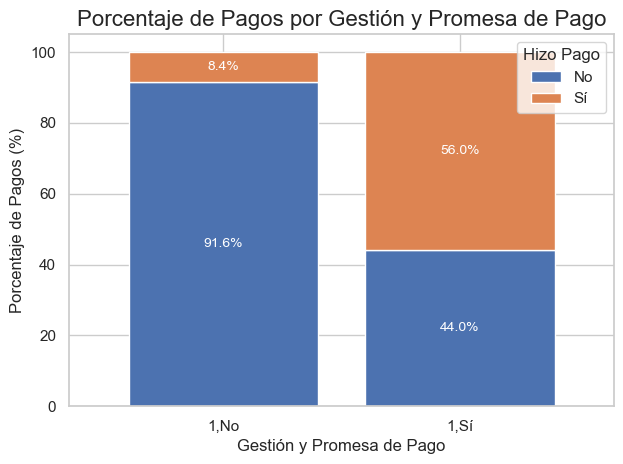

In [22]:
# Agrupamos los datos por 'tuvoGestion', 'tuvoPromesaDePago' y 'hizoPago' para obtener el total de pagos y no pagos
resultadoAgrupaGestion = df_ModeloTFM.groupby(['tuvoGestion', 'tuvoPromesaDePago', 'hizoPago'], observed=False).size().reset_index(name='totalPagos')

# Asegurarnos de que 'hizoPago' sea de tipo string para reemplazar sin problemas
resultadoAgrupaGestion['hizoPago'] = resultadoAgrupaGestion['hizoPago'].astype(str)

# Reemplazar 0 por 'NO' y 1 por 'SI' en 'hizoPago'
resultadoAgrupaGestion['hizoPago'] = resultadoAgrupaGestion['hizoPago'].replace({0: 'No', 1: 'Sí'})

# Reemplazar '1,0' por 'NO' y '1,1' por 'SI' en la columna de 'tuvoPromesaDePago'
resultadoAgrupaGestion['tuvoPromesaDePago'] = resultadoAgrupaGestion['tuvoPromesaDePago'].replace({0: 'No', 1: 'Sí'})

# Calcular los totales por combinación de 'tuvoGestion' y 'tuvoPromesaDePago'
totales_por_grupo = resultadoAgrupaGestion.groupby(['tuvoGestion', 'tuvoPromesaDePago'])['totalPagos'].sum().reset_index(name='totalGestiones')

# Unir los resultados con los totales por grupo
resultadoTotalesGrupo = resultadoAgrupaGestion.merge(totales_por_grupo, on=['tuvoGestion', 'tuvoPromesaDePago'])

# Calcular el porcentaje de pagos realizados
resultadoTotalesGrupo['porcentajePago'] = (resultadoTotalesGrupo['totalPagos'] / resultadoTotalesGrupo['totalGestiones']) * 100

# Mostrar la tabla con los porcentajes calculados
print(resultadoTotalesGrupo[['tuvoGestion', 'tuvoPromesaDePago', 'hizoPago', 'totalPagos', 'totalGestiones', 'porcentajePago']])

# Crear gráfico de barras para mostrar el porcentaje de pagos
plt.figure(figsize=(10, 6))

# Pivotar los datos para obtener los valores de pago y no pago para cada combinación de 'tuvoGestion' y 'tuvoPromesaDePago'
bars = resultadoTotalesGrupo.pivot(index=['tuvoGestion', 'tuvoPromesaDePago'], columns='hizoPago', values='porcentajePago')

# Graficar las barras con los porcentajes
bars.plot(kind='bar', stacked=True, width=0.8)

# Configuración del gráfico
plt.title('Porcentaje de Pagos por Gestión y Promesa de Pago', fontsize=16)
plt.xlabel('Gestión y Promesa de Pago', fontsize=12)
plt.ylabel('Porcentaje de Pagos (%)', fontsize=12)

# Ajustar las etiquetas del eje X para mostrar los valores 'NO' y 'SI'
labels = [f'{int(t[0])},{t[1]}' for t in bars.index]  # Generar las etiquetas
labels = [label.replace('1,0', 'NO') if label == '1,0' else label.replace('1,1', 'SI') for label in labels]  # Reemplazar los valores

plt.xticks(ticks=range(len(labels)), labels=labels, rotation=0)

# Leyenda
plt.legend(title='Hizo Pago', labels=['No', 'Sí'])

# Agregar etiquetas de porcentaje sobre las barras
for p in plt.gca().patches:
    height = p.get_height()
    width = p.get_width()
    x = p.get_x() + width / 2
    y = p.get_y() + height / 2

    # Si la barra tiene un valor, colocar el porcentaje en el centro
    if height > 0:
        porcentaje = f'{height:.1f}%'  # El porcentaje será el valor de altura para cada parte de la barra
        plt.text(x, y, porcentaje, ha="center", va="center", color="white", fontsize=10)

# Mostrar el gráfico
plt.tight_layout()
plt.show()


# 6 CREACION DE MODELOS 

#### Transformación de Rangos a Valores Numéricos Y liminación de Registros con Valores Faltantes en 'hizoPago'

In [23]:
# Función para convertir el rango de texto a valor numérico
def convertir_rango_a_numero(rango):
    try:
        # Eliminar la palabra 'De' y dividir el rango en dos partes
        partes = rango.replace('De ', '').split(' a ')
        # Convertir las partes a valores flotantes, reemplazando comas por puntos
        min_valor = float(partes[0].replace(',', '.'))
        max_valor = float(partes[1].replace(',', '.'))
        # Retornar el promedio de los valores
        return (min_valor + max_valor) / 2
    except Exception as e:
        # Si ocurre algún error (por ejemplo, si el rango está mal formateado), devolver NaN
        return np.nan

# Aplicar la función a las columnas 'rangoIngresoCliente' y 'rangoIngresoConyuge'
df_ModeloTFM['rangoIngresoCliente'] = df_ModeloTFM['rangoIngresoCliente'].apply(convertir_rango_a_numero)
df_ModeloTFM['rangoIngresoConyuge'] = df_ModeloTFM['rangoIngresoConyuge'].apply(convertir_rango_a_numero)

# Reemplazar los valores NaN por 0 de manera explícita (sin inplace=True)
df_ModeloTFM['rangoIngresoCliente'] = df_ModeloTFM['rangoIngresoCliente'].fillna(0)
df_ModeloTFM['rangoIngresoConyuge'] = df_ModeloTFM['rangoIngresoConyuge'].fillna(0)

# Verificar los cambios en las primeras filas de las columnas
print(df_ModeloTFM[['rangoIngresoCliente', 'rangoIngresoConyuge']].head())
# Eliminar registros con valores faltantes en 'hizoPago'
df_ModeloTFM = df_ModeloTFM.dropna(subset=['hizoPago'])


   rangoIngresoCliente  rangoIngresoConyuge
0                  0.0                  0.0
1                  0.0                  0.0
2                  0.0                  0.0
3                  0.0                  0.0
4                  0.0                  0.0


* Selección de variables relevantes
* Definición de variables categóricas y numéricas
* Preprocesamiento de los datos

In [24]:
# Selección de variables relevantes
X = df_ModeloTFM[['edad', 'rangoIngresoCliente', 'rangoIngresoConyuge', 'valorRiesgoGlobal', 
                  'valorRiesgoTotal', 'estadoCivil', 'genero', 'canalGestion', 
                  'tuvoGestion', 'tuvoPromesaDePago', 'valorPagadoPromesa', 'valorPromesa']]
y = df_ModeloTFM['hizoPago']

# Codificar las etiquetas de salida (0 para 'No' y 1 para 'Sí')
y = y.map({'No': 0, 'Sí': 1})

# Crear un preprocesador para las características (asumimos que algunas son numéricas y otras categóricas)
caracteristicas_numericas = X.select_dtypes(include=['int64', 'float64']).columns  # Detectamos características numéricas
caracteristicas_categoricas = X.select_dtypes(include=['object']).columns  # Detectamos características categóricas

# Definir las variables numéricas y categóricas
columnas_categoricas = ['estadoCivil', 'genero', 'canalGestion']
columnas_numericas = ['edad', 'rangoIngresoCliente', 'rangoIngresoConyuge', 'valorRiesgoGlobal', 
                      'valorRiesgoTotal', 'valorPagadoPromesa', 'valorPromesa']

# Preprocesamiento de los datos (imputación y escalado)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),  # Imputar NaN con la media
            ('scaler', StandardScaler())  # Escalar las características numéricas
        ]), columnas_numericas),
        
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputar NaN con la moda (más frecuente)
            ('encoder', OneHotEncoder(handle_unknown='ignore'))  # Codificar las variables categóricas
        ]), columnas_categoricas)
    ]
)

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## 6.1 Módelo Random Forest

Random Forest - Accuracy: 0.8840
Random Forest - F1-Score:
              precision    recall  f1-score   support

           0       0.92      0.95      0.93     57804
           1       0.67      0.55      0.61     11207

    accuracy                           0.88     69011
   macro avg       0.79      0.75      0.77     69011
weighted avg       0.88      0.88      0.88     69011

Random Forest - ROC AUC: 0.8664


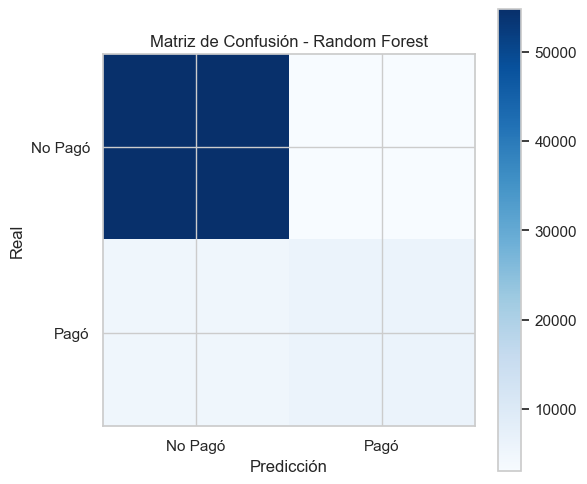

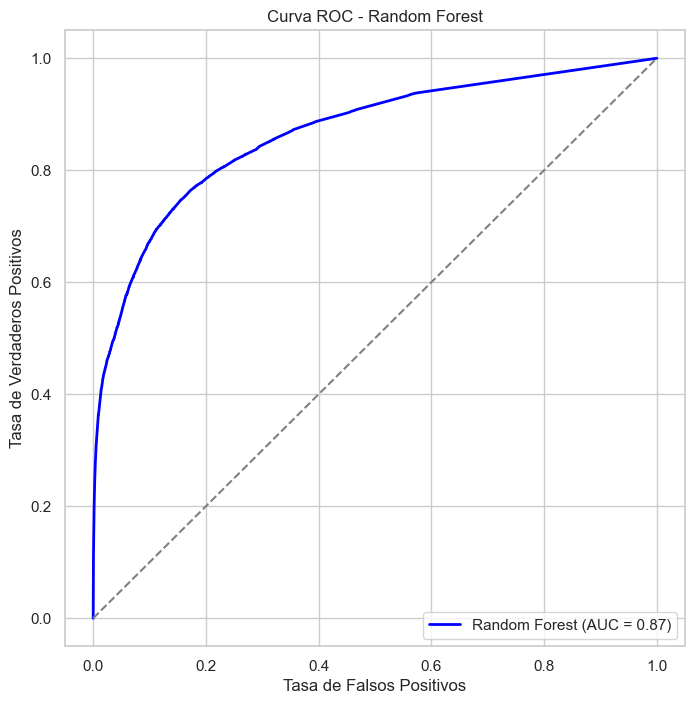

In [25]:
# Crear el modelo Random Forest dentro de un pipeline
modelo_RandomForest = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Preprocesamiento de datos
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))  # Clasificador Random Forest
])

# Entrenar el modelo con los datos de entrenamiento
modelo_RandomForest.fit(X_train, y_train)

# Realizar predicciones sobre el conjunto de prueba
y_pred_rf = modelo_RandomForest.predict(X_test)

# Evaluar el modelo
accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = classification_report(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, modelo_RandomForest.predict_proba(X_test)[:, 1])

# Imprimir los resultados
print(f'Random Forest - Accuracy: {accuracy_rf:.4f}')
print(f'Random Forest - F1-Score:\n{f1_rf}')
print(f'Random Forest - ROC AUC: {roc_auc_rf:.4f}')

# Matriz de confusión
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6,6))
plt.imshow(cm_rf, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Matriz de Confusión - Random Forest")
plt.colorbar()
plt.xticks([0, 1], ['No Pagó', 'Pagó'])
plt.yticks([0, 1], ['No Pagó', 'Pagó'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, modelo_RandomForest.predict_proba(X_test)[:, 1])
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, color='blue', lw=2, label='Random Forest (AUC = {:.2f})'.format(roc_auc_rf))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - Random Forest')
plt.legend(loc='lower right')
plt.show()

## 6.2 Módelo Regresión Logística

Logistic Regression - Accuracy: 0.8716
Logistic Regression - F1-Score:
              precision    recall  f1-score   support

           0       0.88      0.98      0.93     57804
           1       0.79      0.29      0.42     11207

    accuracy                           0.87     69011
   macro avg       0.83      0.64      0.67     69011
weighted avg       0.86      0.87      0.85     69011

Logistic Regression - ROC AUC: 0.8143


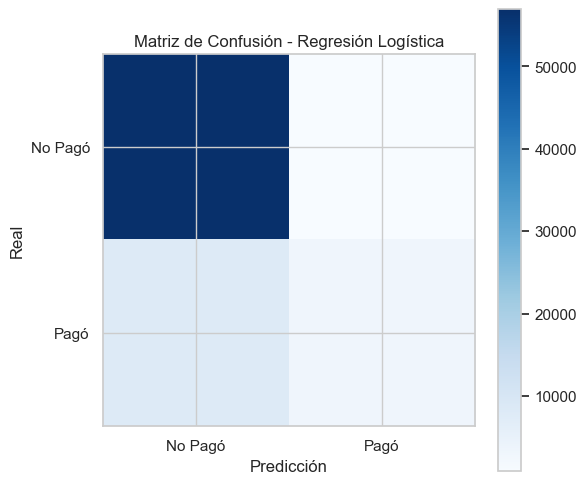

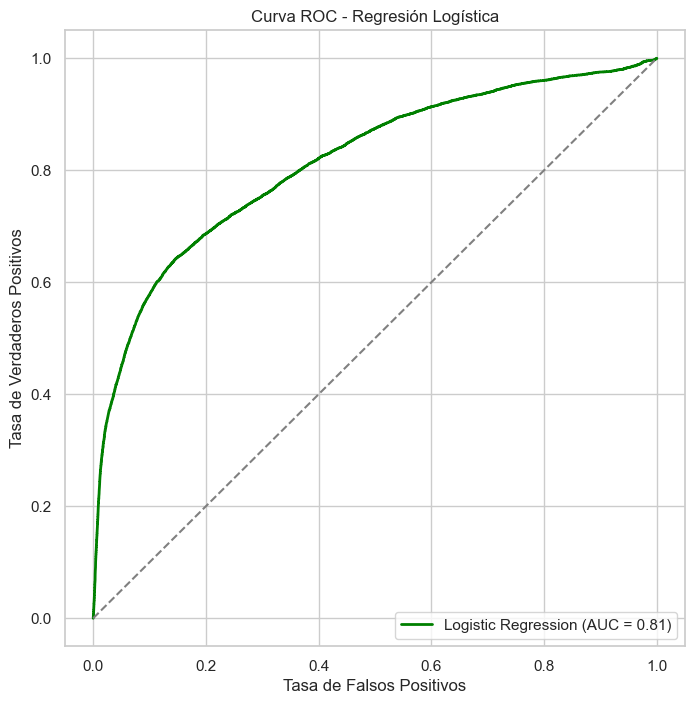

In [26]:
# Crear un pipeline con imputación y el clasificador
modelo_LogisticRegression = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Asegúrate de que preprocessor esté definido correctamente
    ('imputer', SimpleImputer(strategy='mean')),  # Imputar valores faltantes con la media
    ('classifier', LogisticRegression(random_state=42))  # Clasificador de Regresión Logística
])

# Entrenar el modelo con los datos de entrenamiento
modelo_LogisticRegression.fit(X_train, y_train)

# Realizar predicciones sobre el conjunto de prueba
y_pred_lr = modelo_LogisticRegression.predict(X_test)

# Evaluar el modelo
accuracy_lr = accuracy_score(y_test, y_pred_lr)
f1_lr = classification_report(y_test, y_pred_lr)
roc_auc_lr = roc_auc_score(y_test, modelo_LogisticRegression.predict_proba(X_test)[:, 1])

# Imprimir los resultados
print(f'Logistic Regression - Accuracy: {accuracy_lr:.4f}')
print(f'Logistic Regression - F1-Score:\n{f1_lr}')
print(f'Logistic Regression - ROC AUC: {roc_auc_lr:.4f}')

# Matriz de confusión
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6,6))
plt.imshow(cm_lr, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Matriz de Confusión - Regresión Logística")
plt.colorbar()
plt.xticks([0, 1], ['No Pagó', 'Pagó'])
plt.yticks([0, 1], ['No Pagó', 'Pagó'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, modelo_LogisticRegression.predict_proba(X_test)[:, 1])
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, color='green', lw=2, label='Logistic Regression (AUC = {:.2f})'.format(roc_auc_lr))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - Regresión Logística')
plt.legend(loc='lower right')
plt.show()

## 6.3 Modelo Redes Neuronales

Neural Network - Accuracy: 0.8841
Neural Network - F1-Score:
              precision    recall  f1-score   support

           0       0.90      0.97      0.93     57804
           1       0.73      0.46      0.56     11207

    accuracy                           0.88     69011
   macro avg       0.82      0.71      0.75     69011
weighted avg       0.87      0.88      0.87     69011

Neural Network - ROC AUC: 0.8785


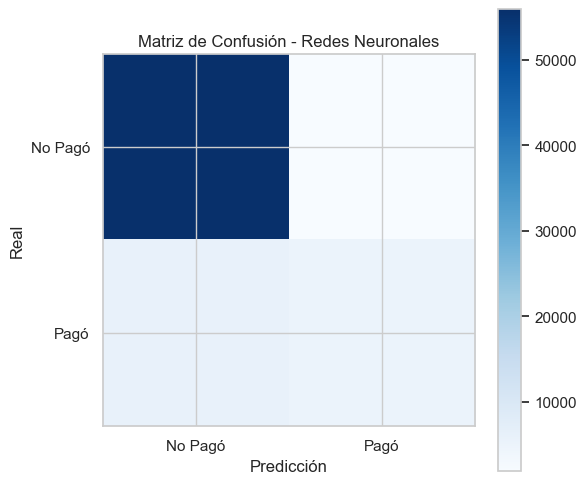

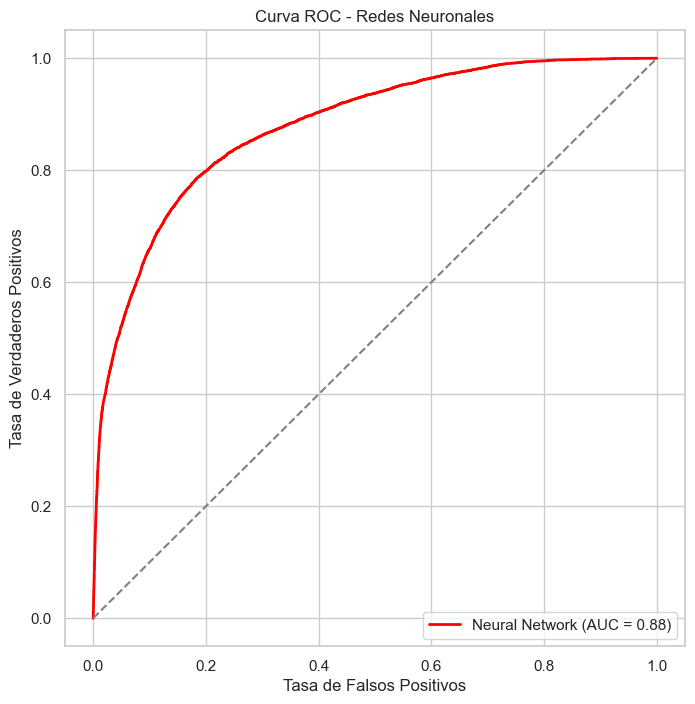

In [27]:
# Crear el modelo de redes neuronales con el pipeline
modelo_NeuralNetwork = Pipeline(steps=[
    ('preprocessor', ColumnTransformer(  # Asegurándonos de que las transformaciones se apliquen a las columnas adecuadas
        transformers=[
            ('num', SimpleImputer(strategy='mean'), columnas_numericas),  # Imputar valores faltantes en las características numéricas
            ('cat', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Imputar valores faltantes en las características categóricas
                ('encoder', OneHotEncoder(handle_unknown='ignore'))  # Codificar las características categóricas
            ]), caracteristicas_categoricas)
        ]
    )),
    ('scaler', StandardScaler()),  # Escalar los datos numéricos
    ('classifier', MLPClassifier(random_state=42, max_iter=500))  # Clasificador de Redes Neuronales
])

# Entrenar el modelo con los datos de entrenamiento
modelo_NeuralNetwork.fit(X_train, y_train)

# Realizar predicciones sobre el conjunto de prueba
y_pred_nn = modelo_NeuralNetwork.predict(X_test)

# Evaluar el modelo
accuracy_nn = accuracy_score(y_test, y_pred_nn)
f1_nn = classification_report(y_test, y_pred_nn)
roc_auc_nn = roc_auc_score(y_test, modelo_NeuralNetwork.predict_proba(X_test)[:, 1])

# Imprimir los resultados
print(f'Neural Network - Accuracy: {accuracy_nn:.4f}')
print(f'Neural Network - F1-Score:\n{f1_nn}')
print(f'Neural Network - ROC AUC: {roc_auc_nn:.4f}')

# Matriz de confusión
cm_nn = confusion_matrix(y_test, y_pred_nn)
plt.figure(figsize=(6,6))
plt.imshow(cm_nn, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Matriz de Confusión - Redes Neuronales")
plt.colorbar()
plt.xticks([0, 1], ['No Pagó', 'Pagó'])
plt.yticks([0, 1], ['No Pagó', 'Pagó'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, modelo_NeuralNetwork.predict_proba(X_test)[:, 1])
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, color='red', lw=2, label='Neural Network (AUC = {:.2f})'.format(roc_auc_nn))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - Redes Neuronales')
plt.legend(loc='lower right')
plt.show()

# 7. Comparación entre modelos.

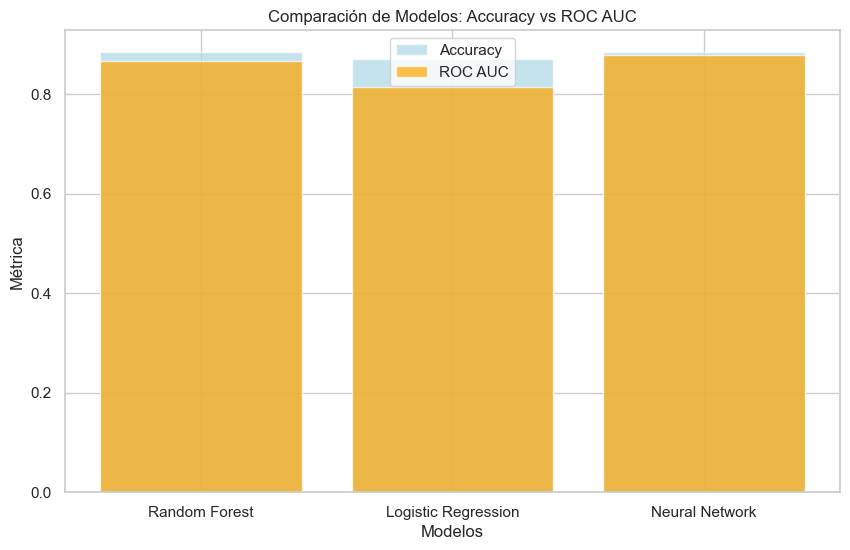

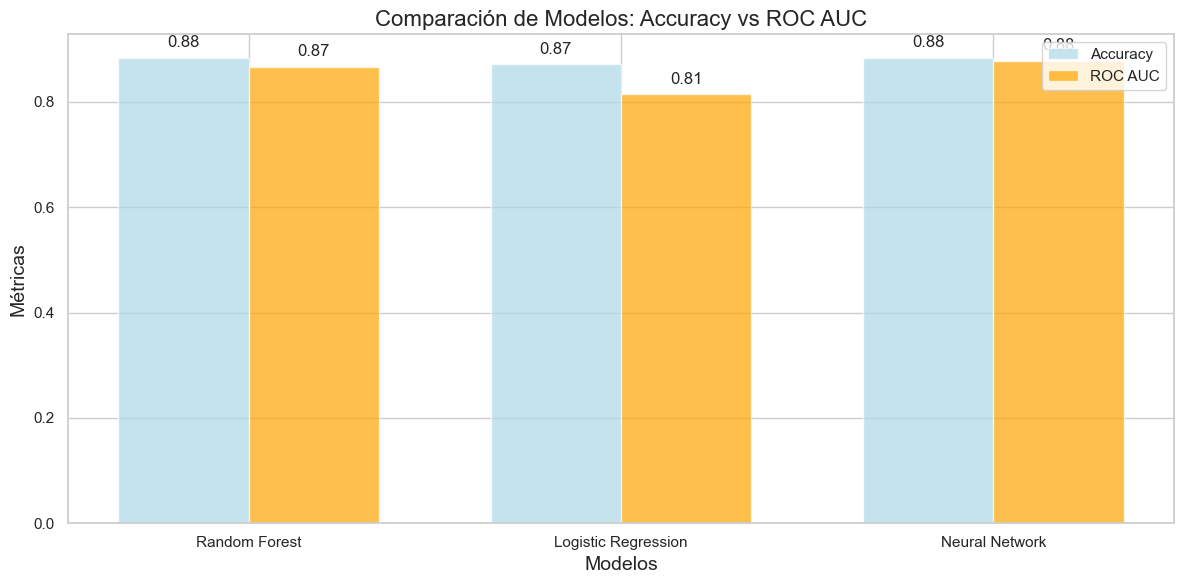

In [28]:
modelos = ['Random Forest', 'Logistic Regression', 'Neural Network']
accuracies = [accuracy_rf, accuracy_lr, accuracy_nn]
roc_auc_scores = [roc_auc_rf, roc_auc_lr, roc_auc_nn]

plt.figure(figsize=(10,6))
plt.bar(modelos, accuracies, color='lightblue', alpha=0.7, label='Accuracy')
plt.bar(modelos, roc_auc_scores, color='orange', alpha=0.7, label='ROC AUC')
plt.xlabel('Modelos')
plt.ylabel('Métrica')
plt.title('Comparación de Modelos: Accuracy vs ROC AUC')
plt.legend()
plt.show()

# Valores de precisión (accuracy) y ROC AUC de los modelos
modelos = ['Random Forest', 'Logistic Regression', 'Neural Network']
accuracies = [accuracy_rf, accuracy_lr, accuracy_nn]
roc_auc_scores = [roc_auc_rf, roc_auc_lr, roc_auc_nn]

# Crear el gráfico de barras comparativo entre Accuracy y ROC AUC
plt.figure(figsize=(12, 6))

# Crear el gráfico de barras para Accuracy
bar_width = 0.35
index = np.arange(len(modelos))

plt.bar(index, accuracies, bar_width, label='Accuracy', color='lightblue', alpha=0.7)
plt.bar(index + bar_width, roc_auc_scores, bar_width, label='ROC AUC', color='orange', alpha=0.7)

# Agregar etiquetas, título y leyenda
plt.xlabel('Modelos', fontsize=14)
plt.ylabel('Métricas', fontsize=14)
plt.title('Comparación de Modelos: Accuracy vs ROC AUC', fontsize=16)
plt.xticks(index + bar_width / 2, modelos)
plt.legend()

# Añadir valores numéricos sobre las barras
for i in range(len(modelos)):
    plt.text(i, accuracies[i] + 0.02, f'{accuracies[i]:.2f}', ha='center', fontsize=12)
    plt.text(i + bar_width, roc_auc_scores[i] + 0.02, f'{roc_auc_scores[i]:.2f}', ha='center', fontsize=12)

# Mostrar el gráfico
plt.tight_layout()
plt.show()


 # 8. Porcentajes de efectividad (accuracy vs ROC AUC)

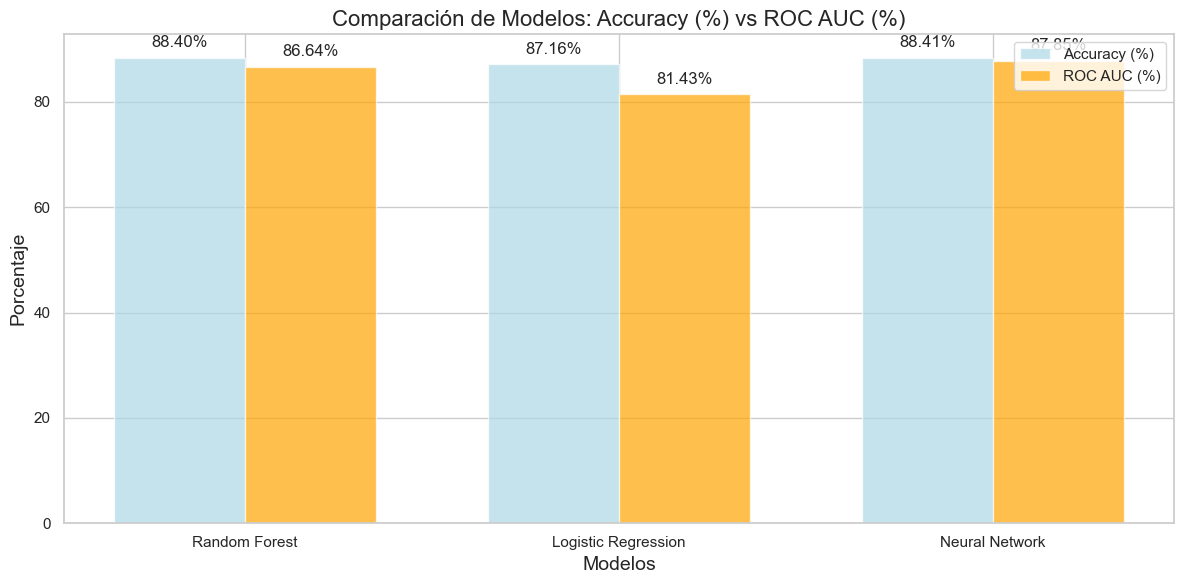

Resultados de Modelos:
Random Forest: Accuracy = 0.88, ROC AUC = 0.87
Logistic Regression: Accuracy = 0.87, ROC AUC = 0.81
Neural Network: Accuracy = 0.88, ROC AUC = 0.88


In [29]:
# Graficar los porcentajes de efectividad (accuracy vs ROC AUC)
percentages = np.array(accuracies) * 100  # Multiplicar por 100 para mostrar en porcentaje
roc_auc_percentages = np.array(roc_auc_scores) * 100

# Crear gráfico de barras para porcentajes
plt.figure(figsize=(12, 6))

plt.bar(index, percentages, bar_width, label='Accuracy (%)', color='lightblue', alpha=0.7)
plt.bar(index + bar_width, roc_auc_percentages, bar_width, label='ROC AUC (%)', color='orange', alpha=0.7)

# Agregar etiquetas, título y leyenda
plt.xlabel('Modelos', fontsize=14)
plt.ylabel('Porcentaje', fontsize=14)
plt.title('Comparación de Modelos: Accuracy (%) vs ROC AUC (%)', fontsize=16)
plt.xticks(index + bar_width / 2, modelos)
plt.legend()

# Añadir valores numéricos sobre las barras
for i in range(len(modelos)):
    plt.text(i, percentages[i] + 2, f'{percentages[i]:.2f}%', ha='center', fontsize=12)
    plt.text(i + bar_width, roc_auc_percentages[i] + 2, f'{roc_auc_percentages[i]:.2f}%', ha='center', fontsize=12)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

# Imprimir los resultados numéricos en la consola para un análisis detallado
print("Resultados de Modelos:")
for model, accuracy, roc_auc in zip(modelos, accuracies, roc_auc_scores):
    print(f'{model}: Accuracy = {accuracy:.2f}, ROC AUC = {roc_auc:.2f}')